# Rethinking Statistics course in pymc3 - Week 10

Lecture 19: Gaussian Processes

- [Video](https://www.youtube.com/watch?v=pwMRbt2CbSU)
- [Slides](https://speakerdeck.com/rmcelreath/l19-statistical-rethinking-winter-2019)

Lecture 20: Missing Values and Measurement Error

- [Video](https://www.youtube.com/watch?v=UgLF0aLk85s)
- [Slides](https://speakerdeck.com/rmcelreath/l19-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week10.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week10_solutions.pdf) for the exercises of the week.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import arviz as az

import warnings
warnings.filterwarnings('ignore')

## Exercise 1

> Consider the relationship between brain volume (`brain`) and body mass (`body`) in the data(`Primates301`). These values are presented as single values for each species. However, there is always a range of sizes in a species, and some of these measurements are taken from very small samples. So these values are measured with some unknown error.

> We don't have the raw measurements to work with—that would be best. But we can imagine what might happen if we had them. Suppose error is proportional to the measurement. This makes sense, because larger animals have larger variation. As a consequence, the uncertainty is not uniform across the values and this could mean trouble.

> Let's make up some standard errors for these measurements, to see what might happen. Load the data and scale the the measurements so the maximum is 1 in both cases:

In [3]:
d = pd.read_csv('../../data/Primates301.csv', header=0, sep=';')
d.dropna(subset=['brain','body'], inplace=True)
d['B'] = d['brain']/np.max(d['brain'])
d['M'] = d['body']/np.max(d['body'])
d['Bse'] = d['B']*0.1
d['Mse'] = d['M']*0.1
d.head()

name           genus       species subspecies  \
0  Allenopithecus_nigroviridis  Allenopithecus  nigroviridis        NaN   
2            Alouatta_belzebul        Alouatta      belzebul        NaN   
3              Alouatta_caraya        Alouatta        caraya        NaN   
4             Alouatta_guariba        Alouatta       guariba        NaN   
5            Alouatta_palliata        Alouatta      palliata        NaN   

   spp_id  genus_id  social_learning  research_effort  brain    body  \
0       1         1              0.0              6.0  58.02  4655.0   
2       3         3              0.0             15.0  52.84  6395.0   
3       4         3              0.0             45.0  52.63  5383.0   
4       5         3              0.0             37.0  51.70  5175.0   
5       6         3              3.0             79.0  49.88  6250.0   

   group_size  gestation  weaning  longevity  sex_maturity  \
0        40.0        NaN   106.15      276.0           NaN   
2         7.4        NaN      NaN        NaN           NaN   
3         8.9     185.92   323.16      243.6       1276.72   
4         7.4        NaN      NaN        NaN           NaN   
5        13.1     185.42   495.60      300.0       1578.42   

   maternal_investment         B         M       Bse       Mse  
0                  NaN  0.118102  0.035808  0.011810  0.003581  
2                  NaN  0.107558  0.049192  0.010756  0.004919  
3               509.08  0.107130  0.041408  0.010713  0.004141  
4                  NaN  0.105237  0.039808  0.010524  0.003981  
5               681.02  0.101533  0.048077  0.010153  0.004808

Now I'll make up some standard errors for B and M, assuming error is 10% of the measurement (_I just did_).

Ignoring measurement error, the corresponding `ulam` (_pymc3_) model is:

In [4]:
Bse = theano.shared(np.array(d['Bse']))
M = theano.shared(np.array(d['M']))
Mse = theano.shared(np.array(d['Mse']))
B = theano.shared(np.array(d['B']))

In [5]:
with pm.Model() as model_11:   
    # Priors
    a = pm.Normal('a', mu=0, sd=1)
    b = pm.Normal('b', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b*np.log(M)
    brain_hat = pm.Lognormal('brain_hat', mu, sigma, observed=B)

    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_11 = pm.sample(tune=3000)
    #posterior_pred_11 = pm.sample_posterior_predictive(posterior_11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:09<00:00, 1439.68draws/s]


Your job is to add the measurement errors to this model. Use the divorce/marriage example in the chapter as a guide. It might help to initialize the unobserved true values of `B` and `M` using the observed values, by adding a list like this to `ulam` (_in pymc3 this is done by defining a `start` parameter in the `pm.sample` function_).

Running the model without measurement error (the code was given in the assignment), we get:

In [6]:
az.summary(posterior_11, var_names=['a','b', 'sigma'], credible_interval=.89).round(2)

mean    sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  ess_sd  \
a      0.42  0.06        0.0      0.0      0.34       0.52     770.0   770.0   
b      0.78  0.01        0.0      0.0      0.76       0.80     819.0   819.0   
sigma  0.29  0.02        0.0      0.0      0.26       0.32    1021.0  1005.0   

       ess_bulk  ess_tail  r_hat  
a         765.0     936.0   1.00  
b         818.0    1011.0   1.01  
sigma    1033.0     859.0   1.01

We'll plot this implied relationship in a moment, after fitting the measurement error model too. To build the measurement error model, all we really need to do is add the observation process. This means that the observed values arise from their own distribution, each having a true value as the mean. We use these unknown true values in the regression. It looks like this:

In [9]:
N = len(d)

with pm.Model() as model_12:    
    # Priors
    sigma = pm.Exponential('sigma', lam=1)
    a = pm.Normal('a', 0., 1.)
    b = pm.Normal('b', 0., 1.)
    
    # Regression for the true values
    M_true = pm.Normal('M_true', mu=0.5, sd=1, shape=N)
    mu = a + b*np.log(M_true)
    B_true = pm.Lognormal('B_true', mu, sigma, shape=N)
    
    # Observed variables
    B_obs = pm.Normal('B_obs', B_true, Bse, observed=B)
    M_obs = pm.Normal('M_obs', M_true, Mse, observed=M)
    
    # Start value and additional kwarg for NUTS and trace definition
    start = dict(B_true=d.B.values, M_true=d.M.values)
    posterior_12 = pm.sample(1000,
                             tune=1000,
                             start=start,
                             nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_true, M_true, b, a, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:31<00:00, 251.14draws/s]


In [10]:
az.summary(posterior_12, var_names=['a','b', 'sigma'], credible_interval=.89).round(2)

mean    sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  ess_sd  \
a      0.42  0.06        0.0      0.0      0.32       0.51    4743.0  4679.0   
b      0.78  0.01        0.0      0.0      0.76       0.81    4753.0  4752.0   
sigma  0.26  0.02        0.0      0.0      0.23       0.29    4990.0  4918.0   

       ess_bulk  ess_tail  r_hat  
a        4774.0    2964.0    1.0  
b        4754.0    3002.0    1.0  
sigma    5002.0    3137.0    1.0

For now, notice that the posterior distributions of a and b are nearly identical to `model_11`. Adding measurement error hasn't changed a thing! Plotting the regression against the observed values:

In [11]:
d['B_true'] = np.mean(posterior_12['B_true'], axis=0)
d['M_true'] = np.mean(posterior_12['M_true'], axis=0)

In [12]:
aux = pd.DataFrame()
aux['x'] = np.arange(len(d))/len(d)
aux['avg_curve'] = np.exp(posterior_12['a'].mean())*aux['x']**(posterior_12['b'].mean())

for i in range(50):
    aux[f'curve_{i}'] = np.exp(posterior_12['a'][i])*aux['x']**(posterior_12['b'][i])

In [13]:
aux_plot = aux.melt(id_vars=['x'],
                    value_vars=aux.columns[2:].tolist(),
                    var_name='posteriors',
                    value_name='y')

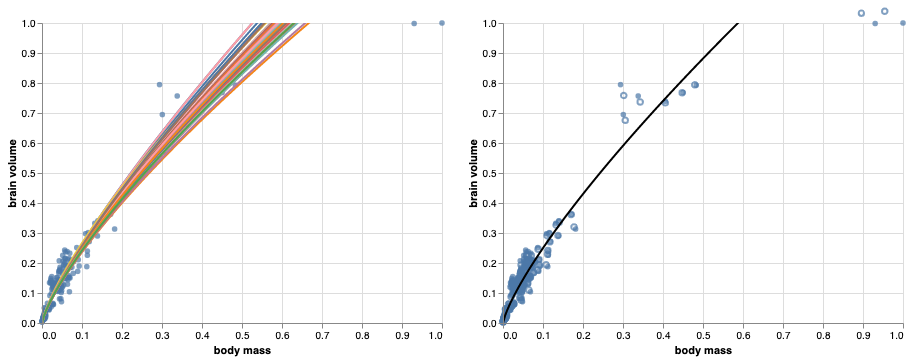

In [14]:
plot = alt.Chart(d)\
   .mark_circle()\
   .encode(
        x=alt.X('M',title='body mass',scale=alt.Scale(domain=(0, 1))),
        y=alt.Y('B',title='brain volume',scale=alt.Scale(domain=(0, 1)))
            )

plot_2 = alt.Chart(aux_plot)\
   .mark_line(clip=True)\
   .encode(
        x=alt.X('x',scale=alt.Scale(domain=(0, 1))),
        y=alt.Y('y',scale=alt.Scale(domain=(0, 1))),
        color = alt.Color('posteriors', legend=None)
            )

plot_3 = alt.Chart(d)\
   .mark_point()\
   .encode(
        x=alt.X('M_true',scale=alt.Scale(domain=(0, 1))),
        y=alt.Y('B_true',scale=alt.Scale(domain=(0, 1)))
            )

plot_4 = alt.Chart(aux)\
   .mark_line(clip=True, color='black')\
   .encode(
        x=alt.X('x',scale=alt.Scale(domain=(0, 1))),
        y=alt.Y('avg_curve',scale=alt.Scale(domain=(0, 1)))
            )

alt.hconcat(plot + plot_2, plot + plot_3 + plot_4)

(_On the left chart_) The two points in the upper right are gorillas. Most primates are small, and obviously gorillas have something special going on.

(_On the right chart_) Now let's plot the estimated values on this. The open points are the posterior mean estimates. Notice that they have moved
towards the regression line, as you'd expect. But even the outlier gorillas haven't moved much. The assumed error just isn't big enough to get them any closer. If you increase the amount of error, you can get all of the species to fall right on the regression line. Try for example 30% error. The model will mix poorly, but take a look at the inferred true values. The truth of this example is that there are just so many small primates that they
dominate the relationship. And their measurement errors are also smaller (in absolute terms). So adding plausible amounts of measurement error here doesn't make a big difference. We still don't have a good explanation for gorillas.

Before moving on, I'll also plot the estimated species values with 50% compatibility ellipses.

In [15]:
aux_ellipse = pd.concat([pd.DataFrame(pm.stats.hpd(posterior_12['B_true'], alpha=0.1)).rename({0:'B_true_lower_hpdi',1:'B_true_upper_hpdi'}, axis=1),
                         pd.DataFrame(pm.stats.hpd(posterior_12['M_true'], alpha=0.1)).rename({0:'M_true_lower_hpdi',1:'M_true_upper_hpdi'}, axis=1),
                         pd.DataFrame(np.mean(posterior_12['B_true'], axis=0)).rename({0:'B_true_avg'}, axis=1),
                         pd.DataFrame(np.mean(posterior_12['M_true'], axis=0)).rename({0:'M_true_avg'}, axis=1)],
                        axis=1)

aux_ellipse['B_true_hpdi'] = abs(aux_ellipse.B_true_lower_hpdi - aux_ellipse.B_true_upper_hpdi)
aux_ellipse['M_true_hpdi'] = abs(aux_ellipse.M_true_lower_hpdi - aux_ellipse.M_true_upper_hpdi)

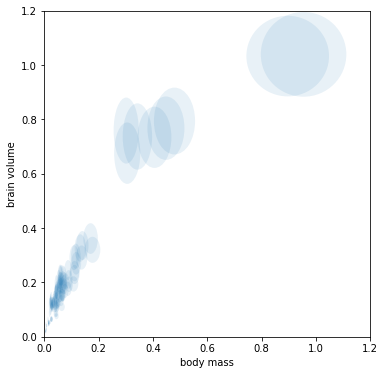

In [16]:
ells = [Ellipse(xy=aux_ellipse.loc[i,['M_true_avg','B_true_avg']].values,
                width=aux_ellipse.loc[i,'M_true_hpdi'],
                height=aux_ellipse.loc[i,'B_true_hpdi'])
        for i in range(len(aux_ellipse))]

fig = plt.figure(0, figsize=(8, 6))
ax = fig.add_subplot(111, aspect='equal')
ax.set_ylabel('brain volume')
ax.set_xlabel('body mass')
for e in ells:
    ax.add_artist(e)
    e.set_alpha(0.1)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)

plt.show()

## Exercise 2

> Now consider missing values, this data set is lousy with them. You can ignore measurement error in this problem. Let's get a quick idea of the missing values by counting them in each variable:

In [2]:
d = pd.read_csv('../../data/Primates301.csv', header=0, sep=';')
d.isna().sum()

name                     0
genus                    0
species                  0
subspecies             267
spp_id                   0
genus_id                 0
social_learning         98
research_effort        115
brain                  117
body                    63
group_size             114
gestation              161
weaning                185
longevity              181
sex_maturity           194
maternal_investment    197
dtype: int64

We’ll continue to focus on just brain and body, to stave off insanity. Consider only those species with measured body masses:

In [3]:
d.dropna(subset=['body'], inplace=True)
d['B'] = d['brain']/np.max(d['brain'])
d['M'] = d['body']/np.max(d['body'])
d.isna().sum()

name                     0
genus                    0
species                  0
subspecies             223
spp_id                   0
genus_id                 0
social_learning         39
research_effort         53
brain                   56
body                     0
group_size              52
gestation               98
weaning                122
longevity              118
sex_maturity           131
maternal_investment    134
B                       56
M                        0
dtype: int64

First, consider whether there is a pattern to the missing values. Does it look like
missing values are associated with particular values of body mass? Draw a DAG that
represents how missingness works in this case. Which type (MCAR, MAR, MNAR)
is this?

Compare the inferences to an analysis that drops all the missing values. Has anything changed? Why or why not? Hint: Consider the density of data in the ranges where there are missing values. You might want to plot the imputed brain sizes together with the observed values.

Looks like the missing brain values are almost all for small bodied species. This implies at least a MAR (dog eats students homework) mechanism. Let's try a DAG to express it:

<img src="../../images/w10_img1.png" width="20%">

`M` here is body mass, `B` (unobserved, suggested by the circle) is brain size, R_B is the missingness mechanism, and `B*` is the observed brain sizes (with missing values). The arrow from `M` to `R_B` indicates that body size influences missingness. In this case, it would imply that small body size makes a missing brain value more likely.

Now let's do some imputation. Remember that the model for imputation is really no different than an ordinary model. It just needs a prior for any variable with missing values. In this case, the missing values are in the outcome, so the likelihood is the prior we need. So the model doesn't change at all.

In [4]:
# PyMC3 can handle missing value quite naturally.
body = d['B'].values.copy()
mask = np.isnan(body)
#body[~mask] = -999
#body = np.ma.masked_values(body, value=-999)
body = np.ma.masked_array(data=body, mask=mask)

In [5]:
M = theano.shared(np.array(d['M']))
B = theano.shared(np.array(d['B']))

In [6]:
with pm.Model() as model_21:   
    # Priors
    a = pm.Normal('a', mu=0, sd=1)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b*np.log(M)
    brain_hat = pm.Lognormal('brain_hat', mu, sigma, observed=body) # please note that body contains masked values
    
    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_21 = pm.sample(tune=2000)
    #posterior_pred_21 = pm.sample_posterior_predictive(posterior_21)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [brain_hat_missing, sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:25<00:00, 117.63draws/s]


Here is the posterior summary for the imputation model:

In [7]:
az.summary(posterior_21, var_names=['a','b', 'sigma'], credible_interval=.89).round(2)

mean    sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  ess_sd  \
a      0.43  0.06        0.0      0.0      0.33       0.51    1333.0  1328.0   
b      0.78  0.01        0.0      0.0      0.76       0.81    1140.0  1137.0   
sigma  0.29  0.02        0.0      0.0      0.27       0.32    1912.0  1902.0   

       ess_bulk  ess_tail  r_hat  
a        1332.0    1340.0    1.0  
b        1140.0    1108.0    1.0  
sigma    1899.0    1321.0    1.0

The same analysis on only complete cases:

In [8]:
d = pd.read_csv('../../data/Primates301.csv', header=0, sep=';')
d.dropna(subset=['body', 'brain'], inplace=True)
d['B'] = d['brain']/np.max(d['brain'])
d['M'] = d['body']/np.max(d['body'])

In [9]:
M = theano.shared(np.array(d['M']))
B = theano.shared(np.array(d['B']))

In [10]:
with pm.Model() as model_22:    
    # Priors
    a = pm.Normal('a', mu=0, sd=1)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = a + b*np.log(M)
    brain_hat = pm.Lognormal('brain_hat', mu, sigma, observed=B)
    
    # Prior sampling, trace definition and posterior sampling
    #prior = pm.sample_prior_predictive()
    posterior_22 = pm.sample(tune=2000)
    #posterior_pred_22 = pm.sample_posterior_predictive(posterior_22)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1527.08draws/s]


In [11]:
az.summary(posterior_22, var_names=['a','b', 'sigma'], credible_interval=.89).round(2)

mean    sd  mcse_mean  mcse_sd  hpd_5.5%  hpd_94.5%  ess_mean  ess_sd  \
a      0.43  0.06        0.0      0.0      0.34       0.52     773.0   762.0   
b      0.78  0.01        0.0      0.0      0.76       0.80     751.0   749.0   
sigma  0.29  0.02        0.0      0.0      0.27       0.31    1166.0  1166.0   

       ess_bulk  ess_tail  r_hat  
a         774.0     899.0   1.00  
b         751.0     978.0   1.00  
sigma    1137.0     870.0   1.01

_Let's add a quick model comparison:_

In [12]:
model_21.name = 'model_11'
model_22.name = 'model_12'

In [13]:
pm.compare({model_21: posterior_21,
            model_22: posterior_22})

WAIC pWAIC dWAIC weight     SE   dSE var_warn
model_12  -869.7  2.46     0      1  37.81     0        0
model_11 -869.41  2.59  0.29      0  37.81  0.03        0

Really no difference from before. Let's plot the imputed values:

In [42]:
d = pd.read_csv('../../data/Primates301.csv', header=0, sep=';')
d.dropna(subset=['body'], inplace=True)
d['B'] = d['brain']/np.max(d['brain'])
d['M'] = d['body']/np.max(d['body'])

In [43]:
aux = pd.concat([pd.DataFrame(d.M[np.isnan(d.loc[:, 'B'])]).reset_index(drop=True),
                 pd.DataFrame(np.mean(posterior_21['brain_hat_missing'], axis=0)).reset_index(drop=True).rename({0:'B'}, axis=1),
                 pd.DataFrame(pm.stats.hpd(posterior_21['brain_hat_missing'], alpha=0.5)).rename({0:'B_lower_hpdi',1:'B_upper_hpdi'}, axis=1)],
                 axis = 1)

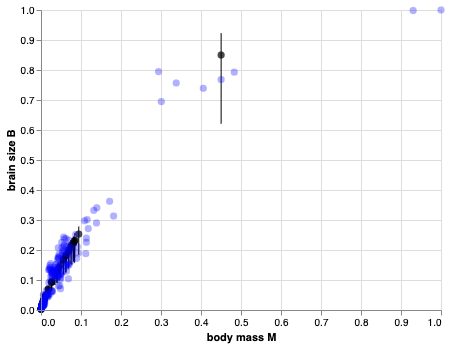

In [44]:
# generate the points
points = alt.Chart(aux).mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('M', title='body mass M',scale=alt.Scale(domain=(0, 1))),
    y=alt.Y('B', title='brain size B',scale=alt.Scale(domain=(0, 1)))
)

points2 = alt.Chart(d).mark_point(
    filled=True,
    size=50,
    color='blue',
    opacity=0.3
).encode(
    x=alt.X('M', scale=alt.Scale(domain=(0, 1))),
    y=alt.Y('B', scale=alt.Scale(domain=(0, 1)))
)

# generate the error bars
errorbars = alt.Chart(aux).mark_errorbar().encode(
    x=alt.X("M"),
    y=alt.Y("B_lower_hpdi:Q", title=None),
    y2="B_upper_hpdi:Q"
)

points + errorbars + points2

Black open points are the imputed values, with 50% compatibility intervals. Imputation hasn't done much, apparently because all but one of the missing values are in a very dense region of the body size range. So almost no information was lost, the missing info is redundant.